In [1]:
class Layer:
    
    #A building block. Each layer is capable of performing two things:
    #- Process input to get output:           output = layer.forward(input)
    
    #- Propagate gradients through itself:    grad_input = layer.backward(input, grad_output)
    
    #Some layers also have learnable parameters which they update during layer.backward.
    
    def __init__(self):
        # Here we can initialize layer parameters (if any) and auxiliary stuff.
        # A dummy layer does nothing
        pass
    
    def forward(self, input):
        # Takes input data of shape [batch, input_units], returns output data [batch, output_units]
        
        # A dummy layer just returns whatever it gets as input.
        return input
    def backward(self, input, grad_output):
        # Performs a backpropagation step through the layer, with respect to the given input.
        
        # To compute loss gradients w.r.t input, we need to apply chain rule (backprop):
        
        # d loss / d x  = (d loss / d layer) * (d layer / d x)
        
        # Luckily, we already receive d loss / d layer as input, so you only need to multiply it by d layer / d x.
        
        # If our layer has parameters (e.g. dense layer), we also need to update them here using d loss / d layer
        
        # The gradient of a dummy layer is precisely grad_output, but we'll write it more explicitly
        num_units = input.shape[1]
        
        d_layer_d_input = np.eye(num_units)
        
        return np.dot(grad_output, d_layer_d_input) # chain rule

In [2]:
class ReLU(Layer):
    def __init__(self):
        # ReLU layer simply applies elementwise rectified linear unit to all inputs
        pass
    
    def forward(self, input):
        # Apply elementwise ReLU to [batch, input_units] matrix
        relu_forward = np.maximum(0,input)
        return relu_forward
    
    def backward(self, input, grad_output):
        # Compute gradient of loss w.r.t. ReLU input
        relu_grad = input > 0
        return grad_output*relu_grad

In [3]:
class Dense(Layer):
    def __init__(self, input_units, output_units, learning_rate=0.1):
        # A dense layer is a layer which performs a learned affine transformation:
        # f(x) = <W*x> + b
        
        self.learning_rate = learning_rate
        self.weights = np.random.normal(loc=0.0, 
                                        scale = np.sqrt(2/(input_units+output_units)), 
                                        size = (input_units,output_units))
        self.biases = np.zeros(output_units)
        
    def forward(self,input):
        # Perform an affine transformation:
        # f(x) = <W*x> + b
        
        # input shape: [batch, input_units]
        # output shape: [batch, output units]
        
        return np.dot(input,self.weights) + self.biases
    
    def backward(self,input,grad_output):
        # compute d f / d x = d f / d dense * d dense / d x
        # where d dense/ d x = weights transposed
        grad_input = np.dot(grad_output, self.weights.T)
        
        # compute gradient w.r.t. weights and biases
        grad_weights = np.dot(input.T, grad_output)
        grad_biases = grad_output.mean(axis=0)*input.shape[0]
        
        assert grad_weights.shape == self.weights.shape and grad_biases.shape == self.biases.shape
        
        # Here we perform a stochastic gradient descent step. 
        self.weights = self.weights - self.learning_rate * grad_weights
        self.biases = self.biases - self.learning_rate * grad_biases
        
        return grad_input

In [4]:
def softmax_crossentropy_with_logits(logits,reference_answers):
    # Compute crossentropy from logits[batch,n_classes] and ids of correct answers
    logits_for_answers = logits[np.arange(len(logits)),reference_answers]
    
    xentropy = - logits_for_answers + np.log(np.sum(np.exp(logits),axis=-1))
    
    return xentropy
def grad_softmax_crossentropy_with_logits(logits,reference_answers):
    # Compute crossentropy gradient from logits[batch,n_classes] and ids of correct answers
    ones_for_answers = np.zeros_like(logits)
    ones_for_answers[np.arange(len(logits)),reference_answers] = 1
    
    softmax = np.exp(logits) / np.exp(logits).sum(axis=-1,keepdims=True)
    
    return (- ones_for_answers + softmax) / logits.shape[0]

TypeError: %i format: a number is required, not numpy.ndarray

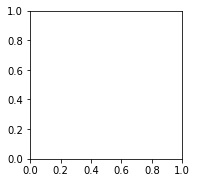

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from typing import Tuple, List, Callable
import matplotlib.pyplot as plt
%matplotlib inline
def load_file(path: str) -> Tuple[np.ndarray, np.ndarray]:
    """Loads the data from the file stored at :param path: and returns the 
    input values and the class labels.
    :param path: path of a CVS file with data
    :return: a tuple containing the input matrix of shape (n, p) and a line 
    vector with the m class labels in {0, ..., 9}
    """
    # citire date sin fisierul dat de path
    df = pd.read_csv(path, header=None)
    X =  df.values[:,1:]
    X =X.reshape((df.shape[1])-1,df.shape[0])
    y = df.values[:,0].reshape(1,len(df))
    assert X.ndim ==  2, 'Matrix required for input values'
    assert y.ndim == 2, 'Column matrix required for labels'
    assert y.shape == (1, X.shape[1]), 'Same number of lines is required'
    return X, y
path_train = './lab4/data/mnist_train.csv'
path_test = './lab4/data/mnist_test.csv'

X_train, y_train = load_file(path_train)

X_test, y_test = load_file(path_test)

## Let's look at some example
plt.figure(figsize=[6,6])
for i in range(4):
    plt.subplot(2,2,i+1)
    plt.title("Label: %i"%y_train[i])
    plt.imshow(X_train[i].reshape([28,28]),cmap='gray');